# RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

## Read the data first

In [1]:
from nb_utils import read_commits

# model files per repository and the elapsed days between the commit and safetensor's release date
df = read_commits()

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']
# count unique repo_url and commit_hash combination in df
num_commits = len(df[['repo_url', 'commit_hash']].drop_duplicates())
num_commits

4738

## Analysis 1: How many commits containing safetensors files were made by the SFconvertbot?

HuggingFace has a bot (https://huggingface.co/SFconvertbot) that converts models to safetensors.
How many commits were made by the bot and how many were made by developers themselves?
Hugging Face bot's source code: https://github.com/huggingface/safetensors/commits/main/bindings/python/convert.py

In [226]:
from pathlib import Path

bot_message = "Adding `safetensors` variant of this model"
df_safetensors_not_by_bot = df_safetensors[~df_safetensors['message'].str.contains(bot_message)]
df_safetensors_by_bot = df_safetensors[df_safetensors['message'].str.contains(bot_message)]


# compute number of unique repo_url and commit_hash combination in df
num_commits = len(df[['repo_url', 'commit_hash']].drop_duplicates())
num_safetensors_commits = len(df_safetensors[['repo_url', 'commit_hash']].drop_duplicates())
num_safetensors_commits_by_bot = len(df_safetensors_by_bot[['repo_url', 'commit_hash']].drop_duplicates())
num_safetensors_commits_not_by_bot = len(df_safetensors_not_by_bot[['repo_url', 'commit_hash']].drop_duplicates())

print(f"# commits: {num_commits}")
print(f"# commits touching safetensor files: {num_safetensors_commits}")
print(f"% commits made by the bot: {num_safetensors_commits_by_bot / num_safetensors_commits * 100:.1f}% ({num_safetensors_commits_by_bot})")
print(f"% commits made by developers: {num_safetensors_commits_not_by_bot / num_safetensors_commits * 100:.1f}% ({num_safetensors_commits_not_by_bot})")


df_safetensors_not_by_bot.to_csv(Path('../../results/safetensors_commits_not_by_bot.csv'), index=False)
df_safetensors_by_bot.to_csv(Path('../../results/safetensors_commits_by_bot.csv'), index=False)

# commits: 4097
# commits touching safetensor files: 436
% commits made by the bot: 85.1% (371)
% commits made by developers: 14.9% (65)


## Analysis 2: Number of elapsed days since the release of safetensors

This script checks how long it took safetensors to first appear in each analyzed repository.

In [227]:
# find the lowest number of elapsed days per unique repo_url
df_safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min()
df_safetensors_first_appearance = df_safetensors_first_appearance.reset_index()
min = df_safetensors_first_appearance['elapsed_days'].min()
max = df_safetensors_first_appearance['elapsed_days'].max()
median = df_safetensors_first_appearance['elapsed_days'].median()
quartile2 = df_safetensors_first_appearance['elapsed_days'].quantile(0.25)
quartile4 = df_safetensors_first_appearance['elapsed_days'].quantile(0.75)
# count number of repos without safetensors
print("Number of analyzed repos: ", len(df['repo_url'].unique()))
print(f"Number of repos without safetensors: {len(df['repo_url'].unique()) - len(df_safetensors_first_appearance)}")
print("Number of repos using safe tensors", len(df_safetensors_first_appearance))
print("min, quartile2, median, quartile4, max=",min, quartile2, median, quartile4, max)

Number of analyzed repos:  844
Number of repos without safetensors: 460
Number of repos using safe tensors 384
min, quartile2, median, quartile4, max= 6 227.75 520.5 551.0 733


## Analysis 3: Plot the number of adoptions per elapsed days

Since the first safetensors release, shows the number of model files using safetensors per elapsed days.

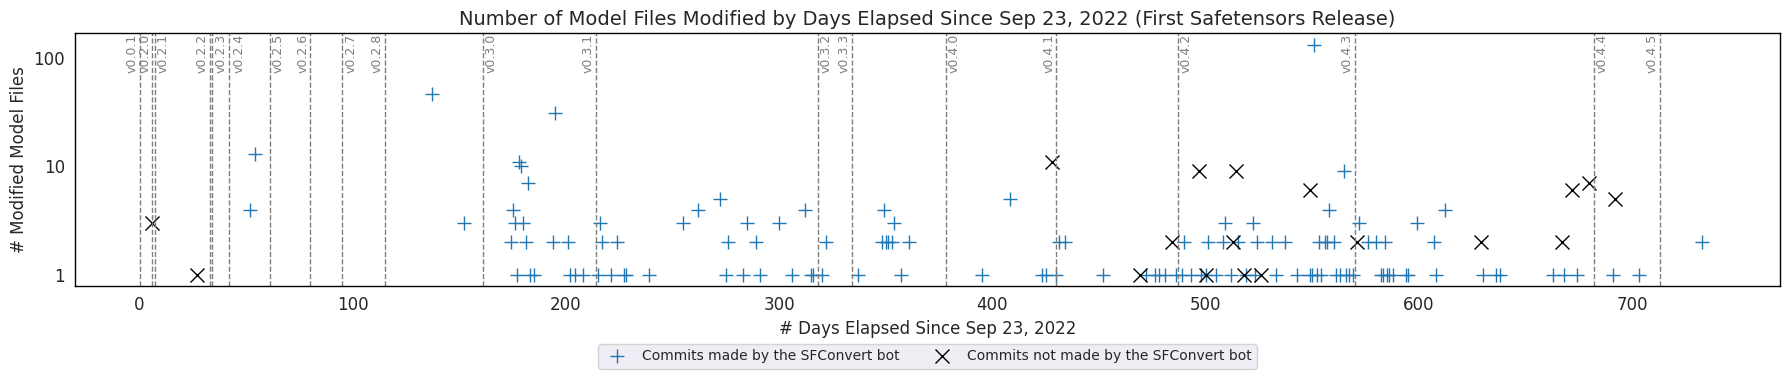

In [228]:
from pathlib import Path
import matplotlib.pyplot as plt
from nb_utils import get_safetensors_releases, SAFETENSORS_RELEASE_DATE

# Group by elapsed days to count files modified on each date
all_commits = df_safetensors['elapsed_days'].value_counts().sort_index()
commits_not_by_bot = df_safetensors_not_by_bot['elapsed_days'].value_counts().sort_index()
commits_by_bot = df_safetensors_by_bot['elapsed_days'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(18,4), facecolor="white")  # Set figure background to white
ax = plt.gca()  # Get the current axis
ax.set_facecolor("white")  # Set axis background to white

# Ensure the visibility of x-axis and y-axis lines (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.0)


plt.plot(commits_by_bot.index, commits_by_bot.values, 
         marker='+', linestyle='None', markersize=10,  label="Commits made by SFConvert bot")
plt.plot(commits_not_by_bot.index, commits_not_by_bot.values, 
         marker='x', linestyle='None', color='black', markersize=10, label="Commits not made by SFConvert bot")

plt.xlabel("# Days Elapsed Since Sep 23, 2022", fontsize=12)
plt.ylabel("# Modified Model Files", fontsize=12)
plt.title("Number of Model Files Modified by Days Elapsed Since Sep 23, 2022 (First Safetensors Release)", fontsize=14)
plt.yscale('log')
plt.yticks([1, 10, 100], ['1', '10', '100'], fontsize=12)
plt.xticks(fontsize=12)
plt.grid(True)
plt.legend(
    ('Commits made by the SFConvert bot','Commits not made by the SFConvert bot'),
    loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
plt.tight_layout()


df_releases  = get_safetensors_releases()

#  add vertical lines for each release date with labels
color, i, x_coordinates = 'tab:gray', 0, [1, -6.5]

for day, label in df_releases[['date', 'tag']].values:
    i = (i + 1) % 2
    diff = (day - SAFETENSORS_RELEASE_DATE).days
    plt.axvline(x=diff,color=color, linestyle='--', linewidth=1)
    x_offset = 1.5 if label == 'v0.2.4' else  x_coordinates[i]
    plt.text(diff + x_offset, plt.ylim()[1] * 0.99, label, color=color, rotation=90, verticalalignment='top', fontdict={'size':9.0})
    if label == 'v0.0.1': i = 2


# Save the plot as a PDF file
plt.savefig(Path('../../results/RQ1CommitsDistribution.pdf'), format="pdf", bbox_inches="tight")

plt.show()

## Analysis 4: Number of adoptions as heatmap

C:\Users\Matt\.virtualenvs\wip-model-evolution-AEl__IAV\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  fig.canvas.draw()
C:\Users\Matt\.virtualenvs\wip-model-evolution-AEl__IAV\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 112 (p) missing from font(s) Noto Emoji.
  fig.canvas.draw()


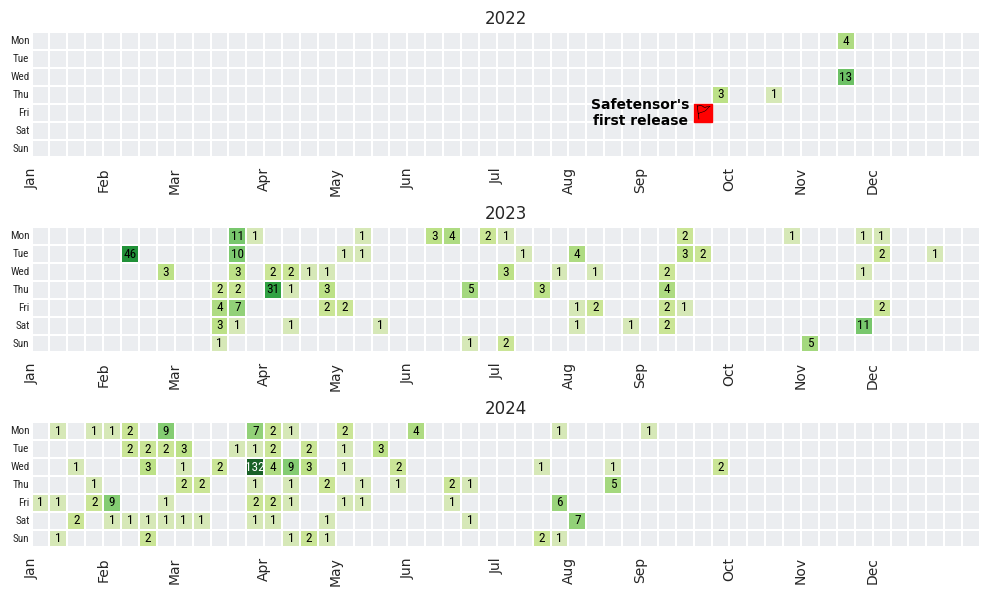

In [239]:
import seaborn as sns
import calendar
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import warnings
from pathlib import Path
from matplotlib.patches import Rectangle
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt



# Create a font property with Noto Emoji and Roboto Condensed fonts
emoji_font = FontProperties(fname=Path('../../assets/NotoEmoji-Regular.ttf'))
color_emoji_font = FontProperties(fname=Path('../../assets/NotoColorEmoji-Regular.ttf'))
roboto_condensed_font = FontProperties(fname=Path('../../assets/RobotoCondensed-Regular.ttf'))
                            
# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans' 
# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = -2  # Decrease this value as needed


# group by timestamp, and ignore the times, just group based on the date
commits_by_date = df_safetensors.groupby(df_safetensors['date'].dt.floor('D')).size().sort_index()

# add all dates from SAFE TENSORS RELEASE DATE to today
for i in range(0, (pd.Timestamp.today() - SAFETENSORS_RELEASE_DATE).days):
    date = SAFETENSORS_RELEASE_DATE + pd.Timedelta(days=i)
    if date not in commits_by_date.index:
        commits_by_date.loc[date] = 0
commits_by_date = commits_by_date.sort_index()
# name the count as 'count'
commits_by_date.name = 'count'

# Ensure 'files_modified_by_date' has datetime as the index if not already
commits_by_date.index = pd.to_datetime(commits_by_date.index)

# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Determine the maximum value across the entire dataset to set a common color range
vmax = commits_by_date.max()

# Apply a log transformation to the commits, offsetting by 1 to handle zero values
log_commits_by_date = np.log1p(commits_by_date)  # log(1 + count)

# Determine the max log-transformed value for setting the consistent color range
vmax_log = log_commits_by_date.max()

# Modify the function to add count annotations on non-zero cells

def plot_year_heatmap_with_annotations(year, ax):
    # Create a DataFrame with dates for the specified year and apply log-transformed data
    year_data = log_commits_by_date[log_commits_by_date.index.year == year]
    year_data_original = commits_by_date[commits_by_date.index.year == year]  # Original counts for annotation
    year_data = year_data.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)
    year_data_original = year_data_original.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)

    # Create a matrix for days (rows) and weeks (columns) for a horizontal layout
    year_matrix = np.zeros((7, 53))
    year_matrix_original = np.zeros((7, 53))

    for i, (date, value) in enumerate(year_data.items()):
        week = date.isocalendar().week - 1
        day = date.weekday()
        year_matrix[day, week] = value
        year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation

    # Plot the heatmap with log-transformed data
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=vmax_log, linewidths=0.1, linecolor='white', square=True,
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Add annotations for non-zero values
    for row in range(7):
        for col in range(53):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=9.5, color='black' if year_matrix_original[row, col] < vmax else 'white', fontproperties=roboto_condensed_font)
                

    # Set title and adjust labels for horizontal orientation
    ax.set_title(f"{year}")
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    # # set font family for the labels
    for label in ax.get_yticklabels():
        label.set_fontproperties(roboto_condensed_font)
        #change font size
        label.set_fontsize(8)
        # make label as close as possible to chart
        label.set_verticalalignment('center')
        # decrease padding
        # label.set_pad(0)
    # 
    # Adjust the month labels along the x-axis
    month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47]
    ax.set_xticks(month_ticks)
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=90)
    
    if year == 2022:
        # Define the day and week position to highlight
        highlight_day = 4  # Example: 2 for Wednesday
        highlight_week = 37  # Example week to highlight
        # Add a red patch to highlight the selected square
        ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red"))
        # Add a text annotation to highlight the selected square
        ax.text(highlight_week - 3, highlight_day + 0.5, "Safetensor's\nfirst release", ha='center', va='center', color="black", fontsize=10, weight='bold')       
        # Add a vertical line to highlight the selected week
        ax.text(highlight_week + 0.5, highlight_day + 0.5, "🚩", fontproperties=emoji_font,
                        ha='center', va='center', fontsize=10, color='black' )
         

# Plot horizontal heatmaps with annotations for non-zero values
fig, axes = plt.subplots(len(years), 1, figsize=(10, 6))

for i, year in enumerate(years):
    plot_year_heatmap_with_annotations(year, axes[i])

plt.tight_layout()




with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.savefig(Path('../../results/RQ1Heatmap.pdf'), bbox_inches='tight', format='pdf')
    plt.savefig(Path('../../results/RQ1Heatmap.png'), bbox_inches='tight', format='png')
    plt.show()

In [230]:
commits_by_date

date
2022-09-23    0
2022-09-24    0
2022-09-25    0
2022-09-26    0
2022-09-27    0
             ..
2024-10-27    0
2024-10-28    0
2024-10-29    0
2024-10-30    0
2024-10-31    0
Name: count, Length: 770, dtype: int64